In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Load data into a DataFrame
df = pd.read_csv("./Resources/working_dataset.csv").set_index("time")
df.index = pd.to_datetime(df.index)
df.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2010-07-18,btc,0.085840,0
2010-07-19,btc,0.080800,0
2010-07-20,btc,0.074736,0
2010-07-21,btc,0.079193,0
2010-07-22,btc,0.058470,0


In [10]:
litecoin = df.loc[df["Symbol"] == "Itc"]
litecoin.head()

,Symbol,PriceUSD,Percent of Change
time,,,
2013-04-01,Itc,1.516680,0
2013-04-02,Itc,4.614541,0
2013-04-03,Itc,4.614541,0
2013-04-04,Itc,5.400204,0
2013-04-05,Itc,3.726269,0


In [11]:
litecoin.count()

Symbol               3622
PriceUSD             3622
Percent of Change    3622
dtype: int64

In [12]:
litecoin_df = litecoin.drop(["Symbol", "Percent of Change"], axis=1)
litecoin_df

,PriceUSD
time,
2013-04-01,1.516680
2013-04-02,4.614541
2013-04-03,4.614541
2013-04-04,5.400204
2013-04-05,3.726269
...,...
2023-02-25,93.226071
2023-02-26,95.185570
2023-02-27,94.015252


In [13]:
def prepare_data(data, sequence_length):
    # Normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    # Split data into training and testing sets
    training_data = scaled_data[:int(0.8*len(data)), :]
    testing_data = scaled_data[int(0.8*len(data)):, :]

    # Create sequences of data
    X_train, y_train = create_sequences(training_data, sequence_length)
    X_test, y_test = create_sequences(testing_data, sequence_length)

    return X_train, y_train, X_test, y_test, scaler


In [14]:
def create_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data)-sequence_length-1):
        X.append(data[i:(i+sequence_length), :])
        y.append(data[i+sequence_length, 0])
    X = np.array(X)
    y = np.array(y)
    return X, y


In [15]:
def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [16]:
# Prepare data
sequence_length = 30
X_train, y_train, X_test, y_test, scaler = prepare_data(litecoin_df.values, sequence_length)

In [17]:
print(f' X (Training) Shape: {X_train.shape}')

 X (Training) Shape: (2866, 30, 1)


In [18]:
# Build model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_model(input_shape)

In [19]:
# Train/Fit LSTM model to training data
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
45/45 [==============================] - 69s 528ms/step - loss: 0.0059 - val_loss: 0.0037
Epoch 2/50
45/45 [==============================] - 15s 330ms/step - loss: 0.0014 - val_loss: 0.0032
Epoch 3/50
45/45 [==============================] - 15s 330ms/step - loss: 0.0011 - val_loss: 0.0033
Epoch 4/50
45/45 [==============================] - 15s 341ms/step - loss: 0.0010 - val_loss: 0.0027
Epoch 5/50
45/45 [==============================] - 16s 358ms/step - loss: 8.8487e-04 - val_loss: 0.0029
Epoch 6/50
45/45 [==============================] - 15s 326ms/step - loss: 8.5214e-04 - val_loss: 0.0019
Epoch 7/50
45/45 [==============================] - 15s 336ms/step - loss: 7.1163e-04 - val_loss: 0.0019
Epoch 8/50
45/45 [==============================] - 15s 325ms/step - loss: 6.5897e-04 - val_loss: 0.0018
Epoch 9/50
45/45 [==============================] - 14s 320ms/step - loss: 6.5888e-04 - val_loss: 0.0016
Epoch 10/50
45/45 [==============================] - 16s 346ms/step - l

22/22 [==============================] - 9s 106ms/step


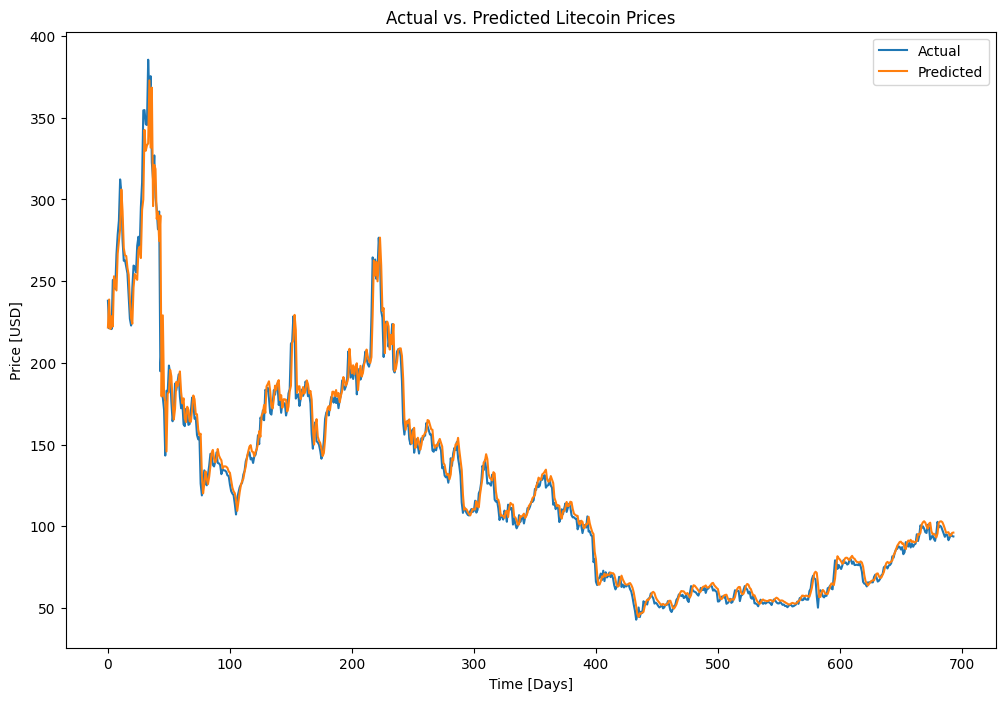

In [20]:
# Make predictions on testing data
predictions = model.predict(X_test)

# Denormalize predictions and actual values
y_pred_inv = scaler.inverse_transform(predictions)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot actual vs predicted prices
plt.figure(figsize=(12, 8))
plt.plot(y_test_inv, label='Actual')
plt.plot(y_pred_inv, label='Predicted')
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.title('Actual vs. Predicted Litecoin Prices')
plt.legend()
plt.show()


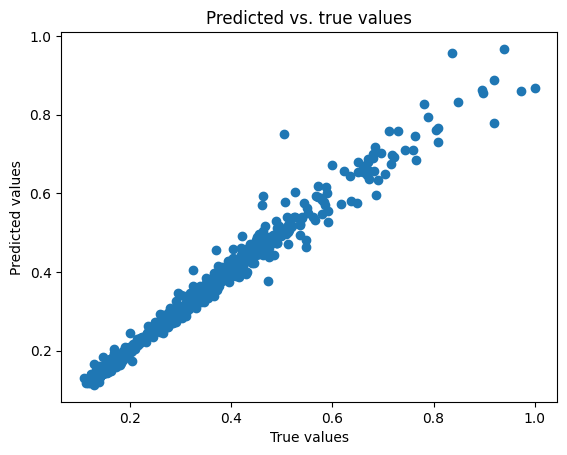

In [21]:
# Plot of the predicted values against the true values, which can help you visualize how well the model is able to predict the crypto prices.
plt.scatter(y_test, predictions)
plt.title('Predicted vs. true values')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.show()

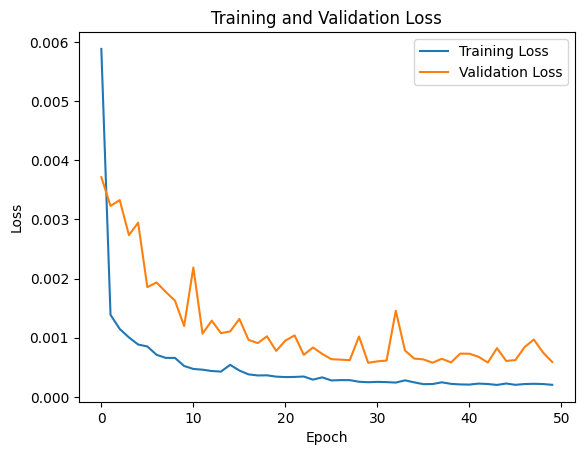

In [22]:
# Plot the training and validation loss over time/epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot a line chart of the training and validation MSE loss over the training epochs.

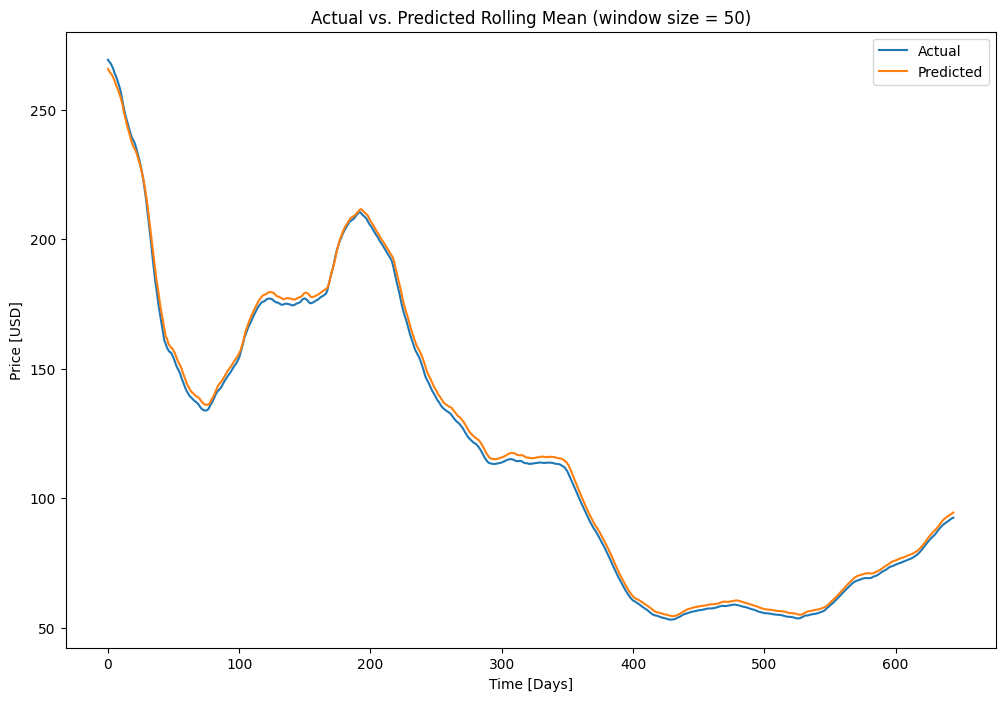

In [23]:
# Plot actual vs predicted prices with a rolling window
window_size = 50
rolling_y_test = pd.Series(y_test_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values
rolling_y_pred = pd.Series(y_pred_inv.reshape(-1)).rolling(window_size).mean()[window_size-1:].values

plt.figure(figsize=(12, 8))
plt.plot(rolling_y_test, label='Actual')
plt.plot(rolling_y_pred, label='Predicted')
plt.title('Actual vs. Predicted Rolling Mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.legend()
plt.show()


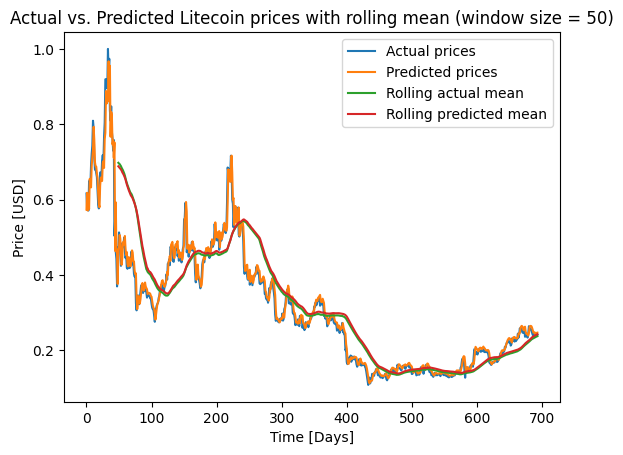

In [24]:
# Assume `y_test` is the actual Litecoin prices and `predictions` is the predicted prices
# Convert them into pandas DataFrame for easier manipulation
y_test_df = pd.DataFrame(y_test, columns=['actual'])
predictions_df = pd.DataFrame(predictions, columns=['predicted'])

# Concatenate the two DataFrames into one
results_df = pd.concat([y_test_df, predictions_df], axis=1)

# Set the window size for the rolling window
window_size = 50

# Calculate the rolling mean for both the actual and predicted prices
results_df['actual_mean'] = results_df['actual'].rolling(window_size).mean()
results_df['predicted_mean'] = results_df['predicted'].rolling(window_size).mean()

# Plot the actual and predicted prices with the rolling mean
plt.plot(results_df['actual'], label='Actual prices')
plt.plot(results_df['predicted'], label='Predicted prices')
plt.plot(results_df['actual_mean'], label='Rolling actual mean')
plt.plot(results_df['predicted_mean'], label='Rolling predicted mean')
plt.legend()
plt.title('Actual vs. Predicted Litecoin prices with rolling mean (window size = {})'.format(window_size))
plt.xlabel('Time [Days]')
plt.ylabel('Price [USD]')
plt.show()


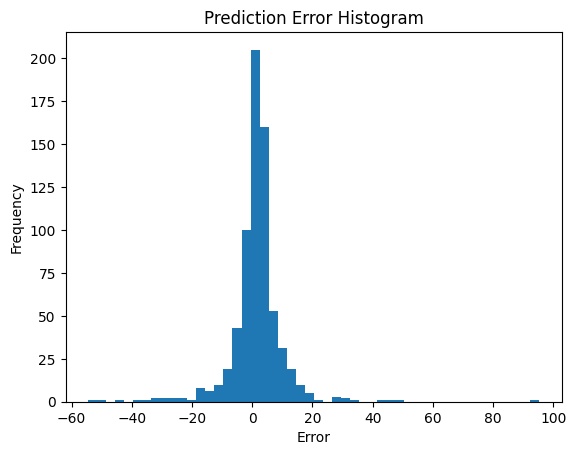

In [25]:
# Calculate prediction errors
errors = y_pred_inv - y_test_inv

# Plot histogram of errors
plt.hist(errors, bins=50)
plt.title('Prediction Error Histogram')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.show()

In [26]:
# Calculate MSE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Compute mean absolute error
mae = mean_absolute_error(y_test, predictions)

# Compute coefficient of determination
r2 = r2_score(y_test, predictions)

# Compute mean squared error using evaluate method
mse_keras = model.evaluate(X_test, y_test)

# Calculate RMSE from MSE
rmse_keras = np.sqrt(mse_keras)

# Compute mean squared error using sklearn
mse_sklearn = mean_squared_error(y_test, predictions)

# Calculate RMSE from MSE
rmse_sklearn = np.sqrt(mse_sklearn)


mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

print('MSE (sklearn):', mse_sklearn)
print('MSE (Keras):', mse_keras)
print('RMSE (Scikit-Learn):', rmse_sklearn)
print('RMSE (Keras):', rmse_keras)
print('MAE:', mae)
print('R²:', r2)

22/22 [==============================] - 3s 121ms/step - loss: 5.8903e-04
MSE (sklearn): 0.0005890284122592769
MSE (Keras): 0.0005890283500775695
RMSE (Scikit-Learn): 0.024269907545338462
RMSE (Keras): 0.02426990626429302
MAE: 0.014133792910118681
R²: 0.9797779122099746


In [27]:
#Note that the Scikit-Learn mean_squared_error() function and the Keras evaluate() method may return slightly different values due to differences in their implementations. However, the RMSE calculated from either one should be similar and can be used to evaluate the performance of the model.

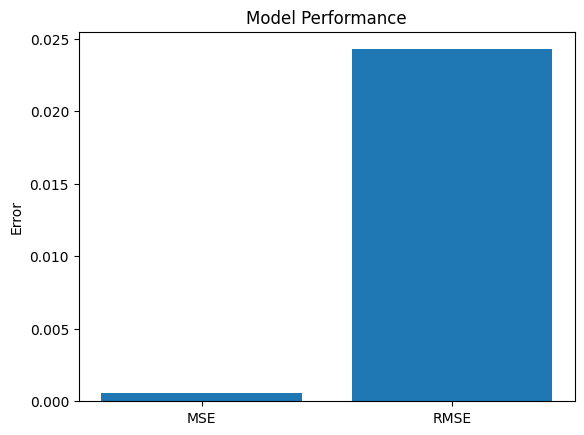

In [28]:
# Plot MSE and RMSE
fig, ax = plt.subplots()
ax.bar(['MSE', 'RMSE'], [mse_keras, rmse_keras])
ax.set_ylabel('Error')
ax.set_title('Model Performance')
plt.show()

In [28]:
# Increase the number of LSTM layers: You can try increasing the number of LSTM layers in the model to capture more complex patterns in the data. However, be careful not to overfit the model.

# Increase the number of neurons in each LSTM layer: You can also try increasing the number of neurons in each LSTM layer to increase the model's capacity to learn.

# Adjust the learning rate: The learning rate determines how fast the model adjusts its weights during training. If the learning rate is too high, the model may overshoot the optimal weights, while if it's too low, the model may take a long time to converge. Experiment with different learning rates to find the best one.

# Use a different optimizer: The optimizer determines how the model updates its weights during training. The default optimizer in Keras is Adam, but you can try different optimizers such as RMSprop or SGD to see if they give better results.

# Increase the number of epochs: Increasing the number of epochs can sometimes improve the model's performance by allowing it to learn more from the data. However, be careful not to overfit the model to the training data.

# Add more features: You can try adding more features to the input data, such as volume or other technical indicators, to give the model more information to work with.

# Use a different sequence length: The sequence length determines how many past time steps the model uses to predict the next time step. Experiment with different sequence lengths to see if they give better results.

# Use different activation functions: Experiment with different activation functions for the LSTM layers and the output layer to see if they give better results.

# Regularize the model: You can try adding regularization techniques such as L1 or L2 regularization or dropout to prevent overfitting.

# Use a different architecture: You can try using a different architecture, such as a convolutional neural network (CNN) or a hybrid model combining CNNs and LSTMs, to see if they give better results for the Bitcoin price prediction task.

# Remember that optimizing an LSTM model is an iterative process, and it may take several experiments to find the best combination of hyperparameters and architecture for your specific task.